<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/dmi_fifa_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIFA 21 Player Dataset

**Data Source:** This dataset comes from [Kaggle's FIFA 21 complete player dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset/data).


The dataset contains 100+ attributes like player positions, with the role in the club and in the national team, player attributes with statistics as Attacking, Skills, Defense, Mentality, GK Skills, etc., and player personal data like Nationality, Club, DateOfBirth, Wage, Salary, etc..


In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import MarkerCluster

from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
# Environment-agnostic data loading: Dynamically configure file path for Colab/local compatibility

if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/players_21.csv'
    html_path = '/content/drive/My Drive/Colab Notebooks/data-mining/fifa_clusters_map.html'
    csv_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/country_coordinates.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/players_21.csv'  # Local path
    html_path = './fifa_clusters_map.html'
    csv_path = './data/country_coordinates.csv'


# 🎨 Global colour palette for all plots
colour_palette = 'deep'
# plasma, deep, pastel, viridis

Mounted at /content/drive


In [3]:
df = pd.read_csv(file_path)

In [4]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,...,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,...,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,...,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3


In [5]:
print("Dataset shape:", df.shape)

Dataset shape: (18944, 106)


In [6]:
df.isnull().sum()

,0
sofifa_id,0
player_url,0
short_name,0
long_name,0
age,0
...,...
lb,0
lcb,0
cb,0
rcb,0


Left-Footed Players: 4496
Right-Footed Players: 14448


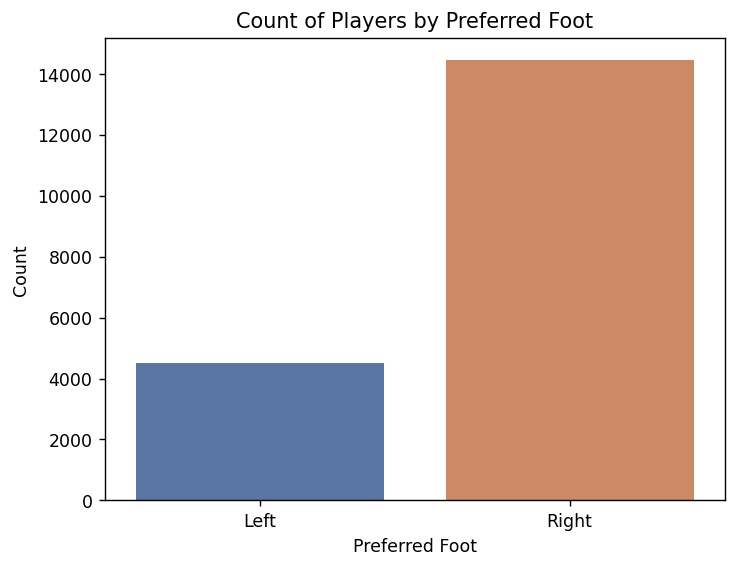

In [7]:
# ⚽ Preferred Foot Distribution

plt.figure(dpi=125)
sns.countplot(x='preferred_foot', data=df, palette=colour_palette)
plt.xlabel('Preferred Foot')
plt.ylabel('Count')
plt.title('Count of Players by Preferred Foot')
Right, Left = df['preferred_foot'].value_counts()
print('Left-Footed Players:', Left)
print('Right-Footed Players:', Right)
plt.show()

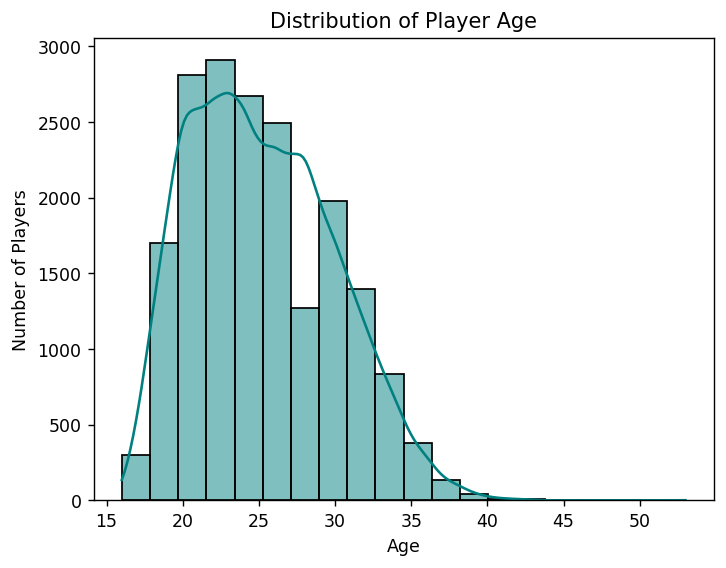

In [8]:
# ⚽ Player Age Distribution

plt.figure(dpi=125)
sns.histplot(df['age'], bins=20, kde=True, color='teal')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.title('Distribution of Player Age')
plt.show()

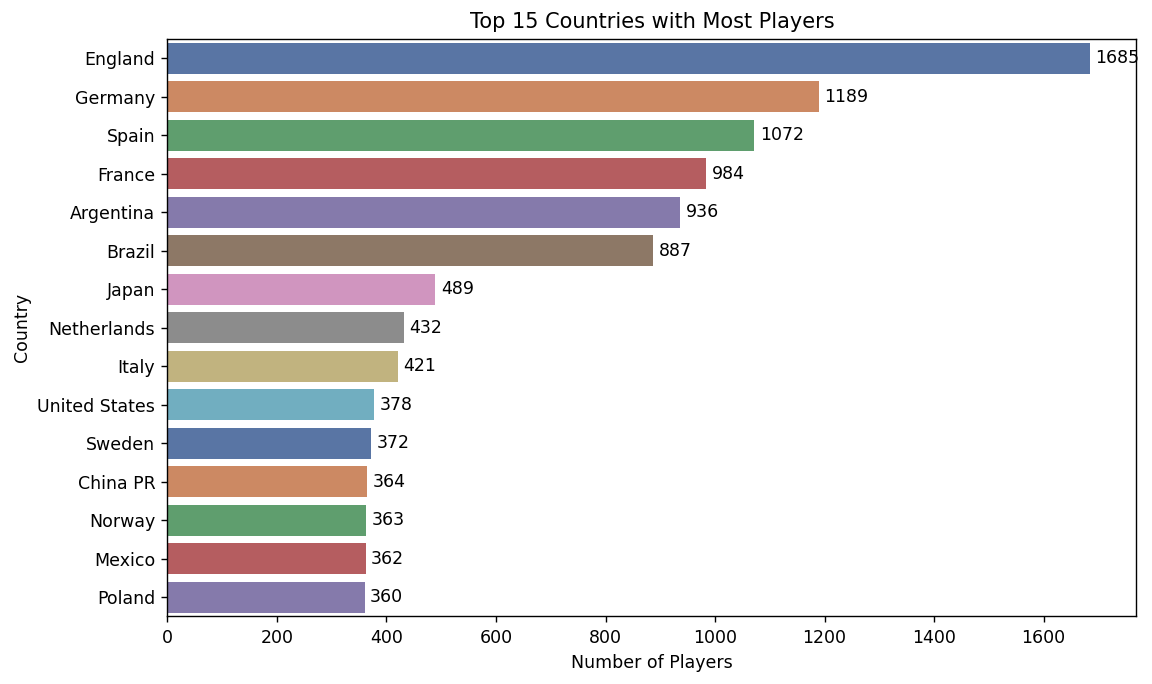

In [9]:
# 🌍 Top 15 Countries by Number of Players (with counts on bars)

plt.figure(figsize=(10,6), dpi=125)
top_countries = df['nationality'].value_counts().head(15)
sns.barplot(x=top_countries.values, y=top_countries.index, palette=colour_palette)

# Add the numbers on the bars
for index, value in enumerate(top_countries.values):
    plt.text(value + 10, index, str(value), va='center')

plt.xlabel('Number of Players')
plt.ylabel('Country')
plt.title('Top 15 Countries with Most Players')
plt.show()

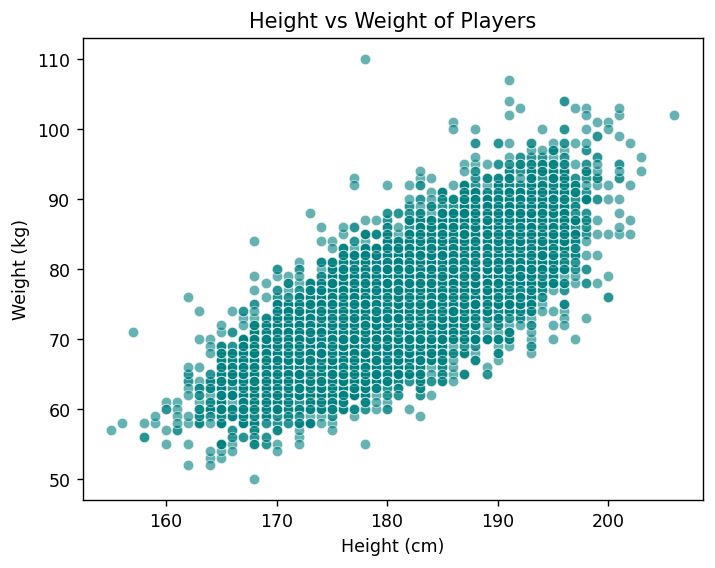

In [10]:
# 🏋️ Relationship between Height and Weight

plt.figure(dpi=125)
sns.scatterplot(x='height_cm', y='weight_kg', data=df, alpha=0.6, color='teal')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.title('Height vs Weight of Players')
plt.show()

In [11]:
# 🎯 Messi vs Ronaldo Radar Chart

# Install if needed
try:
    import plotly.graph_objects as go
except ImportError:
    %pip install plotly
    import plotly.graph_objects as go

# Select Messi and Ronaldo
messi = df[df['short_name'] == 'L. Messi'].iloc[0]
ronaldo = df[df['short_name'] == 'Cristiano Ronaldo'].iloc[0]

# Features to compare
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

messi_stats = [messi[attr] for attr in attributes]
ronaldo_stats = [ronaldo[attr] for attr in attributes]

# Create the radar chart
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=messi_stats,
    theta=attributes,
    fill='toself',
    name='L. Messi'
))

fig.add_trace(go.Scatterpolar(
    r=ronaldo_stats,
    theta=attributes,
    fill='toself',
    name='Cristiano Ronaldo'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 100])
    ),
    showlegend=True,
    title="Messi vs Ronaldo Skill Comparison"
)

fig.show()


In [12]:
# 🎯 Random Comparison Between Two Top-20 Players

import random

# Get the top 20 players by 'overall' rating
top_20_players = df.sort_values('overall', ascending=False).head(20)

# Randomly pick two players
random_players = top_20_players.sample(2, random_state=42)  # fix random_state for reproducibility
player1 = random_players.iloc[0]
player2 = random_players.iloc[1]

# Features to compare
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

player1_stats = [player1[attr] for attr in attributes]
player2_stats = [player2[attr] for attr in attributes]

# Create the radar chart
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=player1_stats,
    theta=attributes,
    fill='toself',
    name=player1['short_name']
))

fig.add_trace(go.Scatterpolar(
    r=player2_stats,
    theta=attributes,
    fill='toself',
    name=player2['short_name']
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 100])
    ),
    showlegend=True,
    title=f"{player1['short_name']} vs {player2['short_name']} Skill Comparison"
)

fig.show()


In [13]:
# Define key performance-related columns for filtering and analysis
key_columns = [
    'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'
]
df[key_columns].isnull().sum()

,0
overall,0
potential,0
value_eur,0
wage_eur,0
player_positions,0
pace,2083
shooting,2083
passing,2083
dribbling,2083
defending,2083


In [14]:
# Remove goalkeepers for classification and clustering tasks
df = df[~df['player_positions'].str.contains('GK')]

In [15]:
# Drop rows that contain missing values in any of the key analysis columns.
# This creates our clean, final dataset (df_cleaned) which will be used
# for all subsequent modelling and exploration tasks. Goalkeepers have
# already been removed, and the data is now limited to outfield players
# with complete data across key metrics like pace, shooting, and value.

# df_cleaned = df.dropna(subset=key_columns)
df_cleaned = df.dropna(subset=key_columns).copy()

df_cleaned.shape

(16860, 106)

In [16]:
# Feature engineering: Calculate Body Mass Index (BMI) and extract primary player position
df_cleaned['BMI'] = df_cleaned['weight_kg'] / ((df_cleaned['height_cm'] / 100) ** 2)
df_cleaned['main_position'] = df_cleaned['player_positions'].apply(lambda x: x.split(',')[0].strip())
df_cleaned.shape

(16860, 108)

In [17]:
# Encode player positions as numerical labels for classification tasks
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_cleaned['position_label'] = le.fit_transform(df_cleaned['main_position'])
df_cleaned.shape

(16860, 109)

In [18]:
# Show mapping of labels
position_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Position label mapping:\n", position_mapping)

Position label mapping:
 {'CAM': np.int64(0), 'CB': np.int64(1), 'CDM': np.int64(2), 'CF': np.int64(3), 'CM': np.int64(4), 'LB': np.int64(5), 'LM': np.int64(6), 'LW': np.int64(7), 'LWB': np.int64(8), 'RB': np.int64(9), 'RM': np.int64(10), 'RW': np.int64(11), 'RWB': np.int64(12), 'ST': np.int64(13)}


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [20]:
# ⚠️ Warning: This GridSearchCV step can take several minutes to run.
# It systematically searches through multiple combinations of parameters.


# Define features and target
# features = ['age', 'height_cm', 'weight_kg', 'pace', 'shooting', 'passing',
#             'dribbling', 'defending', 'physic', 'BMI']
# X = df_cleaned[features]
# y = df_cleaned['main_position']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define model and grid
# clf = DecisionTreeClassifier(random_state=42)
# param_grid = {
#     'max_depth': range(5, 20),
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'criterion': ['gini', 'entropy']
# }

# # Grid search
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy (CV):", grid_search.best_score_)

# Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 15}
# Best accuracy (CV): 0.5383318862102222

In [21]:
features = ['age', 'height_cm', 'weight_kg', 'pace', 'shooting', 'passing',
            'dribbling', 'defending', 'physic', 'BMI']
X = df_cleaned[features]
y = df_cleaned['main_position']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
# 0.55130
clf = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5, min_samples_split=15, random_state=42)

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


Accuracy: 0.5513048635824437
Classification Report:               precision    recall  f1-score   support

         CAM       0.38      0.43      0.40       209
          CB       0.82      0.84      0.83       670
         CDM       0.38      0.51      0.44       318
          CF       0.00      0.00      0.00        22
          CM       0.55      0.65      0.59       461
          LB       0.35      0.28      0.31       287
          LM       0.32      0.35      0.33       219
          LW       0.18      0.02      0.04        89
         LWB       0.00      0.00      0.00        25
          RB       0.41      0.39      0.40       268
          RM       0.28      0.18      0.22       212
          RW       0.26      0.09      0.14        76
         RWB       0.00      0.00      0.00        19
          ST       0.75      0.88      0.81       497

    accuracy                           0.55      3372
   macro avg       0.33      0.33      0.32      3372
weighted avg       0.52     

In [22]:
# ⚠️ Warning: This GridSearchCV step can take several minutes to run.
# It systematically searches through multiple combinations of parameters.

# Define features and target
# features = ['age', 'height_cm', 'weight_kg', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
# df = df.dropna(subset=features + ['player_positions'])  # Clean missing values

# X = df[features]
# y = df['player_positions'].apply(lambda x: x.split(",")[0])  # Primary position only

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the model
# clf = DecisionTreeClassifier(random_state=42)

# # Define parameter grid
# param_grid = {
#     'max_depth': range(5, 20),
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'criterion': ['gini', 'entropy']
# }

# # Grid Search
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)

# Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 2}
# Best accuracy: 0.5461150447756107

In [23]:
# Select features and target
features = ['age', 'height_cm', 'weight_kg', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
df = df.dropna(subset=features + ['player_positions'])  # Clean missing values

X = df[features]
y = df['player_positions'].apply(lambda x: x.split(",")[0])  # Primary position only

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
# clf = DecisionTreeClassifier(max_depth=4, random_state=42) # 0.4533
# clf = DecisionTreeClassifier(max_depth=5, random_state=42) # 0.4909
# clf = DecisionTreeClassifier(max_depth=6, random_state=42) # 0.5161
# clf = DecisionTreeClassifier(max_depth=7, random_state=42) # 0.5375
# clf = DecisionTreeClassifier(max_depth=11, random_state=42) # 0.5383
# clf = DecisionTreeClassifier(max_depth=15, random_state=42) # 0.4951

# 0.5517
clf = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=10, min_samples_split=2, random_state=42) # 0.4951

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


Accuracy: 0.5542704626334519
Classification Report:               precision    recall  f1-score   support

         CAM       0.38      0.43      0.40       209
          CB       0.83      0.85      0.84       670
         CDM       0.40      0.53      0.45       318
          CF       0.00      0.00      0.00        22
          CM       0.55      0.63      0.59       461
          LB       0.35      0.29      0.31       287
          LM       0.32      0.35      0.33       219
          LW       0.00      0.00      0.00        89
         LWB       0.00      0.00      0.00        25
          RB       0.42      0.41      0.41       268
          RM       0.28      0.18      0.22       212
          RW       0.19      0.07      0.10        76
         RWB       0.00      0.00      0.00        19
          ST       0.74      0.88      0.80       497

    accuracy                           0.55      3372
   macro avg       0.32      0.33      0.32      3372
weighted avg       0.52     

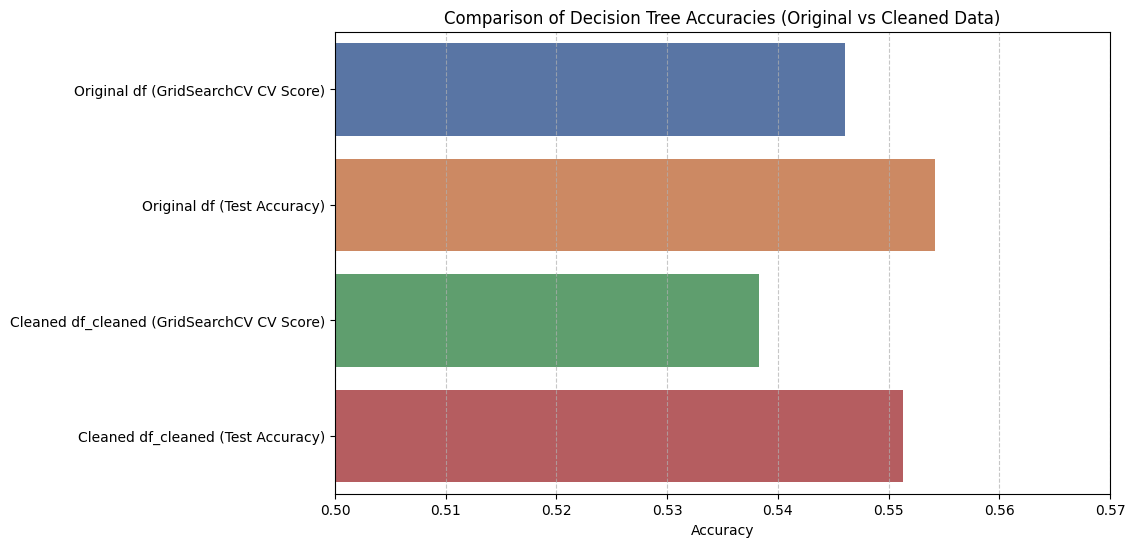

In [24]:
# Data to plot
scenarios = [
    'Original df (GridSearchCV CV Score)',
    'Original df (Test Accuracy)',
    'Cleaned df_cleaned (GridSearchCV CV Score)',
    'Cleaned df_cleaned (Test Accuracy)'
]
accuracies = [0.5461, 0.5542, 0.5383, 0.5513]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=scenarios, palette=colour_palette)
plt.xlabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies (Original vs Cleaned Data)')
plt.xlim(0.5, 0.57)  # Focus zoom on the range where our accuracies are
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [25]:
# df = pd.read_csv(file_path)
# print("Dataset shape:", df.shape)

# # Select numeric features for clustering
# features = ['age', 'overall', 'potential', 'value_eur', 'wage_eur']
# df = df.dropna(subset=features)

# X = df[features]

# # Normalize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply K-Means
# kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# df['Cluster'] = kmeans.fit_predict(X_scaled)

# # Visualize clusters
# plt.scatter(df['overall'], df['value_eur'], c=df['Cluster'], cmap='viridis')
# plt.xlabel('Overall Rating')
# plt.ylabel('Market Value (EUR)')
# plt.title('Player Clusters by Rating and Market Value')
# plt.show()


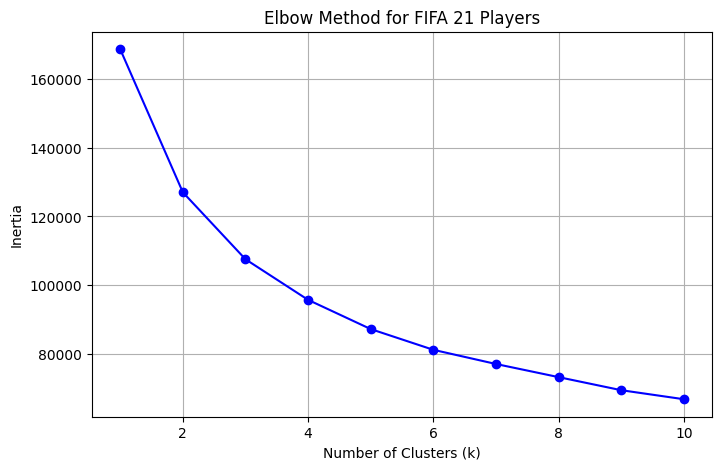

In [26]:
# K-Means Clustering for FIFA 21 Players
# Based on key attributes such as performance metrics and player value
# (Inspired by: Prasetyo et al., 2023)
# This cell might take a few minutes to run - heavy computation involved

# Select relevant features for clustering
kmeans_features = [
    'overall', 'potential', 'pace', 'shooting', 'passing',
    'dribbling', 'defending', 'physic', 'value_eur', 'BMI'
]

X_cluster = df_cleaned[kmeans_features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Use the Elbow Method to find optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for FIFA 21 Players')
plt.grid(True)
plt.show()


In [27]:
# Apply KMeans with chosen number of clusters
# After inspecting the Elbow plot, we'll select k=3 (following the football clustering article)

optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Quick check of cluster distribution
df_cleaned['cluster'].value_counts()


,count
cluster,
1,6595
0,5202
2,5063


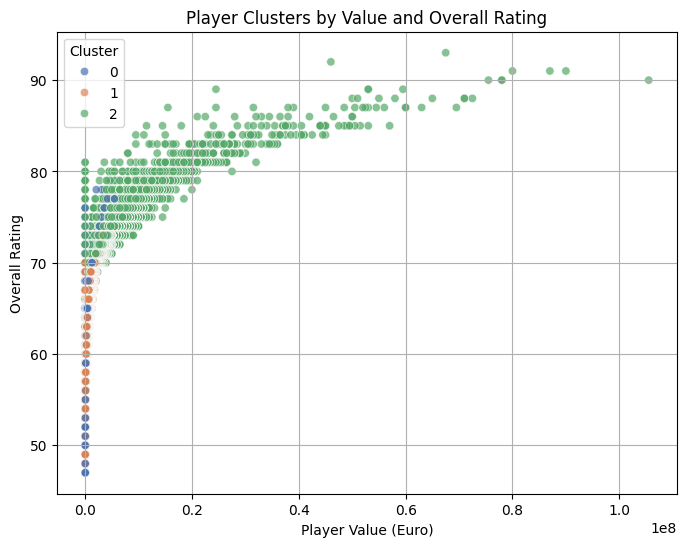

In [28]:
# Visualise clusters based on two important features
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df_cleaned['value_eur'],
    y=df_cleaned['overall'],
    hue=df_cleaned['cluster'],
    palette=colour_palette,
    alpha=0.7
)
plt.title('Player Clusters by Value and Overall Rating')
plt.xlabel('Player Value (Euro)')
plt.ylabel('Overall Rating')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create base map
fifa_map = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodbpositron')

# Marker cluster
marker_cluster = MarkerCluster().add_to(fifa_map)

# Define colours based on player rating
def get_colour(overall):
    if overall >= 85:
        return 'green'
    elif overall >= 75:
        return 'blue'
    else:
        return 'red'

# Load country coordinates from the CSV
coordinates_df = pd.read_csv(csv_path)

# Create a dictionary from the DataFrame
country_coords = dict(zip(coordinates_df['Country'], zip(coordinates_df['Latitude'], coordinates_df['Longitude'])))


# Add markers
for idx, row in df_cleaned.iterrows():
    country = row['nationality']
    overall = row['overall']
    cluster = row['cluster']

    if country in country_coords:
        lat, lon = country_coords[country]
        folium.CircleMarker(
            location=[lat, lon],
            radius=5 + (overall / 20),  # Make bigger for stronger players
            color=get_colour(overall),
            fill=True,
            fill_color=get_colour(overall),
            fill_opacity=0.7,
            popup=folium.Popup(f"{row['short_name']}<br>Overall: {overall}<br>Cluster: {cluster}", max_width=300)
        ).add_to(marker_cluster)

# Save to HTML
fifa_map.save('fifa_clusters_map.html')
print("Map saved as 'fifa_clusters_map.html'. Remember: on Colab you need to pull locally to see it!")



In [ ]:
from IPython.display import IFrame, display, HTML

message = """
<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #e8f5e9;">
    <h3 style="color: #388e3c;">How to View the FIFA Clusters Map</h3>
    <p>⚽️ The FIFA clusters map has been saved to: <b>{}</b>.</p>
    <p>🌍 <b>Important:</b> In Google Colab, local HTML files cannot be viewed directly inside the notebook.</p>
    <ul>
        <li>🔽 Please download the HTML file using the button below.</li>
        <li>🌐 Then open the file manually in your local web browser to see the interactive map.</li>
    </ul>
    <p>💡 Tip: Keeping all files organised using GitHub and Google Drive helps manage the project easily across devices.</p>
</div>
""".format(html_path)

display(HTML(message))

# Optional: offer download in Colab
if 'google.colab' in str(get_ipython()):
    print(f"Map saved at {html_path}.\nDue to Google Colab restrictions, please download and open the file manually to view the map.")
    from google.colab import files
    files.download(html_path)
else:
    display(IFrame(html_path, width=1000, height=600))


In [ ]:
# Note:
# Plotly Express Scatter Mapbox does not automatically group players by cluster and nationality.
# Each player is plotted individually at their nationality’s coordinates.
# As a result, players from the same country overlap on the map, and clusters are not visually grouped.
# This was tested for completeness and visual exploration but not used for final analysis.


# Install Plotly if not already available
try:
    import plotly.express as px
except ImportError:
    %pip install plotly
    import plotly.express as px

# Merge your clustering results with country coordinates
df_plot = df_cleaned.copy()
df_plot['Cluster'] = df_plot['cluster']
df_plot = df_plot.merge(coordinates_df, how='left', left_on='nationality', right_on='Country')

df_plot = df_plot.rename(columns={'Latitude_y': 'Latitude', 'Longitude_y': 'Longitude'})


# Now plot
fig = px.scatter_mapbox(
    df_plot,
    lat='Latitude',
    lon='Longitude',
    color='Cluster',
    hover_name='short_name',
    hover_data={'overall': True, 'potential': True, 'value_eur': True, 'wage_eur': True},
    zoom=1.5,
    height=600
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
fig.show()
